Text preparation, classification, and model assessment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import text data from csv file
df=pd.read_csv('/content/Text_data.csv')
#df.head()
df.tail()
#pd.set_option('max_colwidth', 100)

,Tweet,ADR_label
23511,"At autopsy, the liver was found to be small, s...",0
23512,"Physical exam revealed a patient with aphasia,...",0
23513,At the time when the leukemia appeared seven o...,0
23514,The American Society for Regional Anesthesia a...,0
23515,Concomitant administration of estradiol result...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


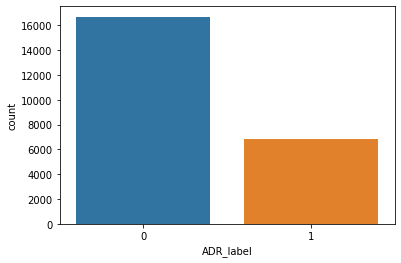

In [2]:
sns.countplot(df.ADR_label) #Imbalanced Target

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import nltk
import string
import re
from nltk.stem.snowball import SnowballStemmer
stopwords=nltk.corpus.stopwords.words('english')
snowball_stemmer=SnowballStemmer(language='english')
def treat_text(text):
    edited_text=re.sub('\W'," ",text) #replace any sumbol with whitespace
    edited_text=re.sub("  "," ",edited_text) #replace double whitespace with single whitespace
    edited_text=edited_text.split(" ") #split the sentence into array of strings
    edited_text=" ".join([char for char in edited_text if char!= ""]) #remove any empty string from text
    edited_text=edited_text.lower() #lowercase
    edited_text=re.sub('\d+',"",edited_text) #Removing numerics
    edited_text=re.split('\W+',edited_text) #spliting based on whitespace or whitespaces
    edited_text=" ".join([snowball_stemmer.stem(word) for word in edited_text if word not in stopwords]) #Snowball Stemmer
    return edited_text
df['Treated_Tweet']=df.Tweet.apply(lambda x: treat_text(x))
df.head()

,Tweet,ADR_label,Treated_Tweet
0,Intravenous azithromycin-induced ototoxicity.,1,intraven azithromycin induc ototox
1,"Immobilization, while Paget's bone disease was...",1,immobil paget bone diseas present perhap enhan...
2,Unaccountable severe hypercalcemia in a patien...,1,unaccount sever hypercalcemia patient treat hy...
3,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...
4,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...


In [5]:
# Most Frequent words in the dataset
df.Treated_Tweet.str.split(expand=True).stack().value_counts()[:10]

patient      6700
case         3804
report       3155
treatment    2975
therapi      2485
develop      2276
year         1988
use          1745
associ       1665
induc        1614
dtype: int64

In [6]:
freq_words=df.Treated_Tweet.str.split(expand=True).stack().value_counts()[:10]
freq_words=list(freq_words.index)

In [7]:
# Rare words in the dataset appearing only once in the whole dataset
df.Treated_Tweet.str.split(expand=True).stack().value_counts()[-20:]

overexpress         1
thrombelastogram    1
stunt               1
caveolar            1
nonsuppress         1
psychoendocrin      1
stratifi            1
yasguri             1
mmole               1
tercica             1
pyridopsoralen      1
neill               1
hepatosplen         1
dienestrol          1
packet              1
court               1
broncheoalveolar    1
gdps                1
melanophag          1
arthrospor          1
dtype: int64

In [8]:
rare_words=df.Treated_Tweet.str.split(expand=True).stack().value_counts()
rare_words=list(rare_words.loc[lambda x: x==1].index)

In [9]:
#Remove Frequent and Rare words
def remove_noise_words(text):
    edited_text=text.split()
    edited_text=[word for word in edited_text if word not in freq_words]
    edited_text=[word for word in edited_text if word not in rare_words]
    edited_text=" ".join(edited_text)
    return edited_text

In [10]:
df['Final_Treated_words']=df.Treated_Tweet.apply(lambda x: remove_noise_words(x))

In [11]:
df.head()

,Tweet,ADR_label,Treated_Tweet,Final_Treated_words
0,Intravenous azithromycin-induced ototoxicity.,1,intraven azithromycin induc ototox,intraven azithromycin ototox
1,"Immobilization, while Paget's bone disease was...",1,immobil paget bone diseas present perhap enhan...,immobil paget bone diseas present perhap enhan...
2,Unaccountable severe hypercalcemia in a patien...,1,unaccount sever hypercalcemia patient treat hy...,sever hypercalcemia treat hypoparathyroid dihy...
3,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...,method two pseudoporphyria caus naproxen oxapr...
4,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...,method two pseudoporphyria caus naproxen oxapr...


In [12]:
X=df.Final_Treated_words
y=df.ADR_label

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=10)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18812,)
(4704,)
(18812,)
(4704,)


In [15]:
#Creating a list of Pipeline with well-known ML models
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

pipelines=[]
for model in [DecisionTreeClassifier(), MultinomialNB(), ComplementNB(), 
              LogisticRegression(solver='saga'), RidgeClassifier(solver='auto'), SVC(),RandomForestClassifier()]:
    pipeline=make_pipeline(TfidfVectorizer(), model)
    pipelines.append(pipeline)

In [16]:
#Training the model
import time
training_time=[]
for pipeline in pipelines:
    start=time.time()
    pipeline.fit(X_train, y_train)
    stop=time.time()
    training_time.append(stop-start)

In [17]:
#Prediction from test dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
model_name=[]
precision_array=[]
recall_array=[]
f1_array=[]
test_time=[]
print("Classifiation Report\n")
print("*****************************************************")
for i, pipeline in enumerate(pipelines):
    start=time.time()
    y_pred=pipeline.predict(X_test)
    stop=time.time()
    test_time.append(stop-start)
    print(pipelines[i].steps[1][0].upper())
    model_name.append(pipelines[i].steps[1][0].upper())
    f1_array.append(round(f1_score(y_test, y_pred, average='weighted'),2))
    precision_array.append(round(precision_score(y_test, y_pred, average='binary'),2))
    recall_array.append(round(recall_score(y_test, y_pred, average='binary'),2))
    print("\n",classification_report(y_test, y_pred))
    print("*****************************************************")

Classifiation Report

*****************************************************
DECISIONTREECLASSIFIER

               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3357
           1       0.67      0.71      0.69      1347

    accuracy                           0.82      4704
   macro avg       0.78      0.79      0.78      4704
weighted avg       0.82      0.82      0.82      4704

*****************************************************
MULTINOMIALNB

               precision    recall  f1-score   support

           0       0.84      0.96      0.90      3357
           1       0.85      0.54      0.66      1347

    accuracy                           0.84      4704
   macro avg       0.85      0.75      0.78      4704
weighted avg       0.84      0.84      0.83      4704

*****************************************************
COMPLEMENTNB

               precision    recall  f1-score   support

           0       0.92      0.81      0.86      33

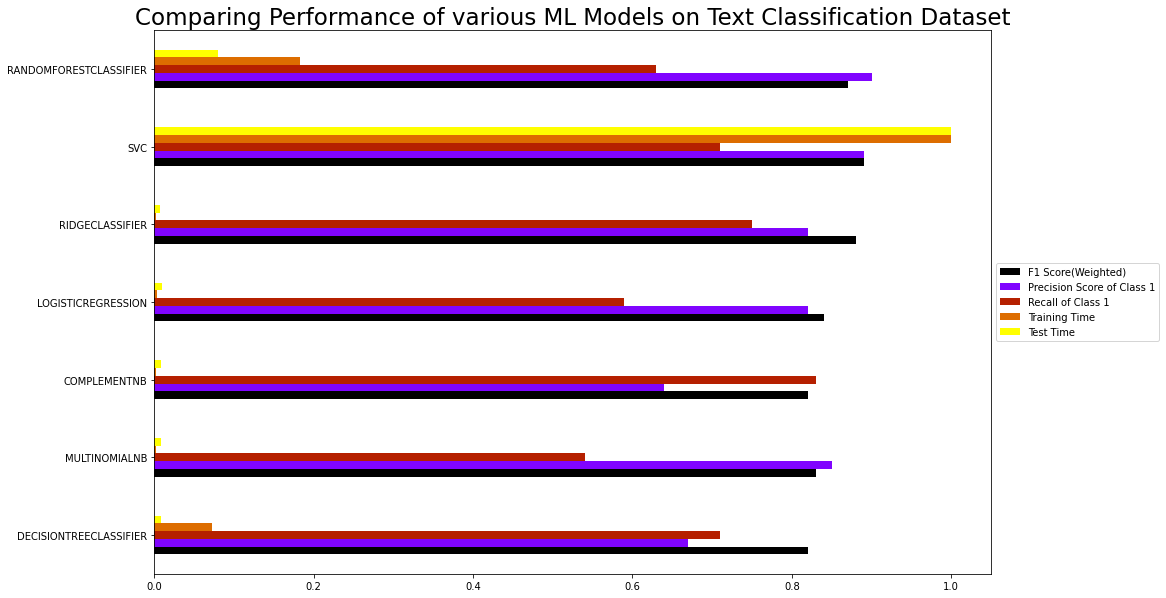

In [18]:
#Plotting the various performance metrix of all models
training_time=np.array(training_time)/np.max(training_time)
test_time=np.array(test_time)/np.max(test_time)
score_df=pd.DataFrame({'F1 Score(Weighted)':f1_array,
                     'Precision Score of Class 1':precision_array,
                     'Recall of Class 1':recall_array,
                      'Training Time': training_time,
                      'Test Time':test_time}, index=model_name)

f=plt.figure(figsize=(15,10))
plt.title('Comparing Performance of various ML Models on Text Classification Dataset', color='black',
         fontdict={'fontsize':23})
score_df.plot(kind='barh', ax=f.gca(), cmap='gnuplot')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Text summary

In [19]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.summarization import summarize
# load data
filename = '/content/Europe_Covid.txt'
file = open(filename, 'rt')
text = file.read()
file.close()
print ('Summary:')
print (summarize(text))

2021-10-26 12:20:05,815 : INFO : 'pattern' package not found; tag filters are not available for English
2021-10-26 12:20:05,830 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-10-26 12:20:05,832 : INFO : built Dictionary(171 unique tokens: ['affect', 'case', 'class', 'contin', 'countri']...) from 23 documents (total 257 corpus positions)


Summary:
European countries are reporting record numbers of Covid-19 cases as the continent prepares for the pandemic to intensify through winter.Those affected include Europe's political class.
Polish President Andrzej Duda tested positive for Covid-19 on Friday, according to a tweet from Presidential Minister Blazej Spychalski Saturday.
Duda's diagnosis comes as the country reported 13,632 new cases Friday, the highest daily tally since the pandemic began.
On the same day France reported 42,032 new cases in 24 hours, a new record, according to the French Health Agency.
